# アクティブラーニングと半教師あり学習
アクティブラーニングと半教師あり学習についてMNISTのデータセットを用いて学びます。 

In [1]:
from chainer import Chain, configuration
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam
from chainer.datasets import mnist
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater, Trainer
from chainer.training.extensions import PrintReport, LogReport, Evaluator
from sklearn.model_selection import train_test_split
from chainer import serializers
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

/Users/yuza/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## データの取得
MNISTのデータをトレーニングデータとテストデータに分けた状態でダウンロードします。

In [2]:
train_all, test =  mnist.get_mnist(ndim=3)

print(train_all._datasets[0].shape)
print(train_all._datasets[1].shape)
print(test._datasets[0].shape)
print(test._datasets[1].shape)

(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


次にトレーニングデータについて、ラベリングされたものとラベリングされて無いものを分けます。ここでは5000データのみラベリング済みとし、10000データがラベリングされてないものとします。

In [3]:
num_initial_data = 5000

x_train = train_all._datasets[0][:num_initial_data]
x_train_sub = train_all._datasets[0][num_initial_data:][:10000]
y_train = train_all._datasets[1][:num_initial_data]
#y_train_sub = train_all._datasets[1][1000:]

print(x_train.shape)
print(x_train_sub.shape)
print(y_train.shape)

(5000, 1, 28, 28)
(10000, 1, 28, 28)
(5000,)


## ラベリングされたデータを用いてのモデルの学習
まずラベリングされたトレーニングデータ5000データを学習させます。  
以下はchainerに読み込ませるための変換を行います。

In [4]:
def merge_data(x,y):
    return [(x[i,:], y[i]) for i in range(len(x))]

train = merge_data(x_train,y_train)

モデルを作成し、学習させます。  
※今回はデモなので時間削減のため、5000データをある程度学習させたモデルパラメータをあらかじめ読み込みます。  
学習後、モデルパラメータを読み込みます。

In [5]:
class Model(Chain):
    def __init__(self):
        super(Model, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(1, 16, ksize=3)
            self.batch = L.BatchNormalization(16)
            self.linear = L.Linear(10)
    
    def __call__(self, x):
        h = self.conv(x)
        h = F.relu(h)
        h = F.max_pooling_2d(h, ksize=3)
        h = self.batch(h)
        h = self.linear(h)
        return h

In [6]:
model = Model()
serializers.load_npz("model_initial", model)
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)
train_iterator = SerialIterator(train, batch_size=100, repeat=True)
test_iterator = SerialIterator(test, batch_size=100, shuffle=False, repeat=False)
updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
trainer = Trainer(updater, (100, 'iteration'))
trainer.extend(Evaluator(test_iterator, classifier), trigger=(10, 'iteration'), name="test")
trainer.extend(PrintReport(['iteration', "main/loss", "test/main/loss"]))

logreport = LogReport(trigger=(10, 'iteration'))
trainer.extend(logreport)
trainer.run()
serializers.save_npz('model', model)

iteration   main/loss   test/main/loss
10          0.0060729   0.108515        
20          0.00697613  0.121079        
30          0.00984654  0.113697        
40          0.00820407  0.110952        
50          0.00843164  0.119867        
60          0.00511516  0.11353         
70          0.00345013  0.112007        
80          0.0040657   0.11467         
90          0.00410856  0.110514        


テストデータを用いて分類精度を確認してみましょう。  

In [7]:
from sklearn.metrics import classification_report

with configuration.using_config('train', False):
    predicts = model(np.array([data[0] for data in test], dtype=np.float32))
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts, axis=1)

print("*** Scores for Test data ***")
print(classification_report(np.array([data[1] for data in test], dtype=np.float32), predicts_y))

*** Scores for Test data ***
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       980
        1.0       0.98      0.99      0.98      1135
        2.0       0.96      0.96      0.96      1032
        3.0       0.97      0.96      0.97      1010
        4.0       0.96      0.98      0.97       982
        5.0       0.97      0.96      0.96       892
        6.0       0.98      0.98      0.98       958
        7.0       0.97      0.95      0.96      1028
        8.0       0.96      0.93      0.95       974
        9.0       0.94      0.96      0.95      1009

avg / total       0.97      0.97      0.97     10000



この時点でもある程度の精度は出ていますが、ラベリングされたデータを追加して学習させることによりより高い精度がだせるモデルを作っていきます。

## 半教師あり学習とアクティブラーニング
続いて半教師あり学習とアクティブラーニングの２つを用いてラベリングを効率的に行い、それをモデルに学習させていきます。　
### ◯半教師あり学習：  
ある程度学習させたモデルに対して、ラベリングされてないデータについて分類確率を予測させ、
測結果をラベルづけを行います。これは半教師あり学習の中でもブートストラップ法と呼ばれます。
### ◯アクティブラーニング：
予測が曖昧になってしまうデータを選びそれに対して人工的にラベリングする方法。ここではラベリングされてないデータについて分類結果を予測させた時に「1番目に確率の高いラベル」の確率ー「2番目に確率の高いラベル」の確率　が
小さくなるデータを選び、それに対してのみ人の手でラベルづけを行います。

In [8]:

#アクティブラーニングに用いる「1番目に確率の高いラベル」の確率ー「2番目に確率の高いラベル」の確率　が小さくなるデータを選びます。
def get_low_margin(proba, bound):
    lm = []
    for i in range(len(proba)):
        margin = proba[i][np.argsort(proba[i])][-1] - proba[i][np.argsort(proba[i])][-2]
        if margin < bound:
            lm.append([i,margin])
    return lm

#半教師あり学習に用いる予測の信頼度の高いデータのみ選びます。
def get_high_proba(proba, bound):
    hp = []
    for i in range(len(proba)):
        for p in range(len(proba[i])):
            if proba[i,p] > bound:
                hp.append([i,p])
    return hp

def getdata_from_index(data,index):
    return data[index]

#アクティブラーニングに関しては手動でラベリングします。
def add_label(x_train,index):
    selected_x_train = getdata_from_index(x_train,index)
    labels = []
    for i,d in enumerate(selected_x_train):
        print("{0}/{1}".format(i+1,selected_x_train.shape[0]))
        plt.imshow(np.reshape(d,[28,28]),cmap="gray_r")
        plt.show()
        label = input("enter label here")
        labels.append(int(label))
    print("finished")
    selected_x_train = selected_x_train[:len(labels)]
    return selected_x_train,labels

#半教師あり学習とアクティブラーニングによってラベリングし、そのデータを学習データに入れます。
def concat_data(proba,x_train,y_train,x_train_sub,proba_limit, margin_limit):
    print("total number of data is {0}".format(x_train_sub.shape[0]))
    lm = get_low_margin(proba, margin_limit)
    print("number of data with first and second choice probability lower than {0}: {1}".format(margin_limit,len(lm)))
    hp = get_high_proba(proba, proba_limit)
    print("number of data with probability higher than {0}: {1}".format(proba_limit,len(hp)))
    lm_index = np.array(lm,dtype = "int64")[:,0]
    lm_x_train, lm_y_train = add_label(x_train_sub,lm_index)
    
    hp_index = np.array(hp,dtype = "int64")[:,0]
    hp_x_train = getdata_from_index(x_train_sub,hp_index)
    hp_y_train = np.array(hp,dtype = "int64")[:,1]
    
    selected_index = np.concatenate((lm_index,hp_index))   
    selected_x_train = np.concatenate((lm_x_train,hp_x_train))
    selected_y_train = np.concatenate((lm_y_train,hp_y_train))
    
    new_x_train = np.concatenate((x_train,selected_x_train))
    new_y_train = np.concatenate((y_train,selected_y_train))
    new_x_train_sub = np.delete(x_train_sub,selected_index,axis=0)
    
    print("{0} was added to training data".format(selected_x_train.shape[0]))
    
    return new_x_train,new_y_train,new_x_train_sub

In [9]:
#モデルの出力をsoftmax関数により確率に変換します。
def softmax(x):
    exp_x = np.exp(x)
    y = exp_x / np.sum(np.exp(x), axis=1, keepdims=True)
    return y

proba = softmax(model(x_train_sub).data)

total number of data is 10000
number of data with first and second choice probability lower than 0.01: 5
number of data with probability higher than 0.95: 9069
1/5


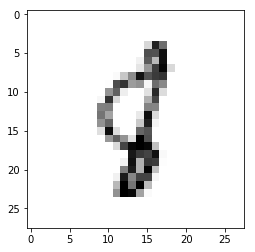

enter label here8
2/5


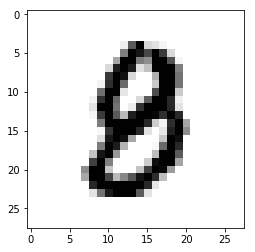

enter label here8
3/5


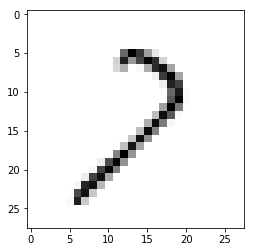

enter label here7
4/5


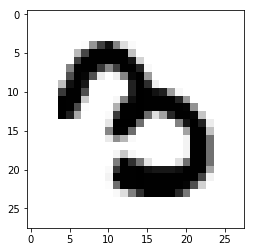

enter label here3
5/5


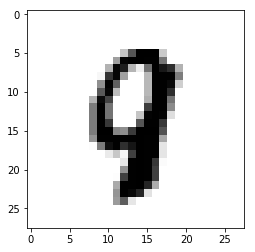

enter label here9
finished
9074 was added to training data


In [10]:
x_train,y_train,x_train_sub = concat_data(proba,x_train,y_train,x_train_sub ,proba_limit = 0.95, margin_limit = 0.01 )

半教師あり学習とアクティブラーニングにより、データがラベリングされました。その後のデータ数を確認しましょう。

In [11]:
print(x_train.shape)
print(x_train_sub.shape)
print(y_train.shape)

(14074, 1, 28, 28)
(926, 1, 28, 28)
(14074,)


## 再学習
以降は同じ内容を繰り返し、ラベリングを行います。
新しく得られたラベリングされたデータを含むデータを用いて再度学習を行います。モデルパラメータは先ほど保存したものを使います。

In [ ]:
train = merge_data(x_train,y_train)

In [ ]:
model = Model()
serializers.load_npz("model", model)
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)
train_iterator = SerialIterator(train, batch_size=100, repeat=True)
test_iterator = SerialIterator(test, batch_size=100, shuffle=False, repeat=False)
updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
trainer = Trainer(updater, (100, 'iteration'))
trainer.extend(Evaluator(test_iterator, classifier), trigger=(10, 'iteration'), name="test")
trainer.extend(PrintReport(['iteration', "main/loss", "test/main/loss"]))

logreport = LogReport(trigger=(10, 'iteration'))
trainer.extend(logreport)
trainer.run()
serializers.save_npz('model', model)

iteration   main/loss   test/main/loss
10          0.00329909  0.115291        
20          0.00558301  0.115123        
30          0.00296275  0.127474        
40          0.00429712  0.117477        
50          0.00317604  0.11245         
60          0.00366437  0.117579        


再度半教師あり学習とアクティブラーニングを行います。

In [ ]:
proba = softmax(model(x_train_sub).data)
x_train,y_train,x_train_sub = concat_data(proba,x_train,y_train,x_train_sub ,proba_limit = 0.95, margin_limit = 0.01 )

データ数を確認しましょう。

In [ ]:
print(x_train.shape)
print(x_train_sub.shape)
print(y_train.shape)

以降はこのサイクルを繰り返して行くことで、ラベリングとモデルの学習を行なっていきます。